In [1]:
# CELL 1: Load CSV and Basic Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from nilearn import plotting, image
import matplotlib.pyplot as plt

# Load subject info from CSV
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Session start mapping (for special cases)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

'''
# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10, # 10, 11, 12 are the same contrasts as 1, 2, 4
    'word': 12,
    'object': 3,
    'house': 11
}
'''

# Cope mapping: Key -> (Cope Number, Multiplier)
# Multiplier 1  = Use contrast as is (e.g., Face > Scramble)
# Multiplier -1 = Invert contrast (e.g., Face > Word becomes Word > Face)

COPE_MAP = {
    'face':   (10, 1),   # Face > Scramble
    'word':   (13, -1),  # Face > Word (INVERTED to create Word > Face)
    'object': (3,  1),   # Object > Scramble
    'house':  (11, 1)    # House > Scramble
}

# Parcels are touchy. 
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform', 'inferiortemporal'], # needed to add IT to capture VWFA
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

print("✓ CSV loaded and configuration set")

✓ CSV loaded and configuration set


In [2]:
# CELL 2: Streamlined Subject Loading and Configuration
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Streamlined subject loading with proper configuration"""
    
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        # Get available sessions
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
        
        # Proper hemisphere mapping
        if row['patient'] == 1:  # Patients
            hemisphere_full = row.get('intact_hemi', 'left')
            hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        else:  # Controls 
            hemisphere = 'r'  # Default for controls (we'll add bilateral later)
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None,
            'surgery_side': row.get('SurgerySide', None) if row['patient'] == 1 else None
        }
    
    return subjects

# Load subjects systematically
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)

# Start with original subjects only
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print("STREAMLINED SUBJECT LOADING COMPLETE")
print("="*50)
print(f"Patients loaded: {len(ALL_PATIENTS)}")
print(f"  - OTC: {len(OTC_PATIENTS)}")
print(f"  - nonOTC: {len(NON_OTC_PATIENTS)}")
print(f"Controls loaded: {len(ALL_CONTROLS)}")
print(f"Total analysis subjects: {len(ANALYSIS_SUBJECTS)}")

print(f"\nCORRECT CATEGORY_PARCELS:")
for category, parcels in CATEGORY_PARCELS.items():
    print(f"  {category:6s}: {parcels}")

print(f"\nSample subjects:")
for subj_id, info in list(ANALYSIS_SUBJECTS.items())[:3]:
    print(f"  {info['code']}: {info['group']} {info['patient_status']}, hemi='{info['hemi']}'")

STREAMLINED SUBJECT LOADING COMPLETE
Patients loaded: 16
  - OTC: 7
  - nonOTC: 9
Controls loaded: 9
Total analysis subjects: 25

CORRECT CATEGORY_PARCELS:
  face  : ['fusiform']
  word  : ['fusiform', 'inferiortemporal']
  object: ['lateraloccipital']
  house : ['parahippocampal', 'lingual', 'isthmuscingulate']

Sample subjects:
  OTC004: OTC patient, hemi='l'
  nonOTC007: nonOTC patient, hemi='r'
  OTC008: OTC patient, hemi='l'


In [3]:
# CELL 3: Functional ROI Extraction (FIXED IMPORTS)
from scipy.ndimage import label, center_of_mass # <--- THIS WAS MISSING
import numpy as np
import nibabel as nib

def extract_functional_rois_bilateral(subject_id, threshold_z=2.3, min_cluster_size=30):
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in COPE_MAP.items():
            # Unpack Tuple
            cope_num, multiplier = cope_params if isinstance(cope_params, tuple) else (cope_params, 1)
            
            # Load Search Mask
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): continue
            
            try:
                search_mask = nib.load(mask_file).get_fdata() > 0
                affine = nib.load(mask_file).affine
            except: continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): continue
                
                try:
                    # Load & Invert
                    zstat = nib.load(cope_file).get_fdata() * multiplier
                    
                    # Threshold
                    suprathresh = (zstat > threshold_z) & search_mask
                    
                    # Cluster & Filter
                    labeled, n_clusters = label(suprathresh) # <--- This is where it failed
                    if n_clusters == 0: continue
                    
                    best_idx = -1
                    max_peak = -999
                    
                    for i in range(1, n_clusters + 1):
                        cluster_mask = (labeled == i)
                        if np.sum(cluster_mask) >= min_cluster_size:
                            peak_val = np.max(zstat[cluster_mask])
                            if peak_val > max_peak:
                                max_peak = peak_val
                                best_idx = i
                    
                    if best_idx == -1: continue 
                    
                    # Save Result
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': zstat[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask
                    }
                except Exception as e: print(f"Err {subject_id} {category}: {e}")

    return all_results

# EXECUTE
print("Re-running extraction...")
golarai_functional_final = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_functional_rois_bilateral(sub, min_cluster_size=30)
    if res: golarai_functional_final[sub] = res
print(f"✓ Extraction Complete: {len(golarai_functional_final)} subjects.")

Re-running extraction...
✓ Extraction Complete: 24 subjects.


In [4]:
# CELL 4: Verify Selectivity (Tuple Corrected)
def verify_roi_selectivity(functional_results, subjects, sample_ids=['OTC004', 'control025']):
    print("\nROI SELECTIVITY CHECK")
    print("="*40)
    
    for pid in sample_ids:
        # Find full ID
        sid = next((k for k,v in subjects.items() if v['code'] == pid), None)
        if not sid or sid not in functional_results: continue
        
        print(f"\n>> {pid}:")
        res = functional_results[sid]
        first_ses = subjects[sid]['sessions'][0]
        
        for roi_name in sorted(res.keys()):
            if first_ses not in res[roi_name]: continue
            roi_mask = res[roi_name][first_ses]['roi_mask']
            target_cat = roi_name.split('_')[1]
            
            scores = {}
            feat_dir = BASE_DIR / sid / f'ses-{first_ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            for cat, (cope, mult) in COPE_MAP.items():
                f = feat_dir / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
                if f.exists():
                    d = nib.load(f).get_fdata() * mult
                    scores[cat] = np.mean(d[roi_mask])
            
            top = max(scores, key=scores.get)
            mark = "✓" if top == target_cat else "✗"
            print(f"  {roi_name:10s}: {mark} Top={top} (Target: {scores.get(target_cat,0):.2f})")
            
verify_roi_selectivity(golarai_functional_final, ANALYSIS_SUBJECTS)


ROI SELECTIVITY CHECK

>> OTC004:
  l_face    : ✓ Top=face (Target: 2.67)
  l_house   : ✓ Top=house (Target: 3.08)
  l_object  : ✓ Top=object (Target: 3.53)
  l_word    : ✓ Top=word (Target: 2.90)

>> control025:
  l_face    : ✓ Top=face (Target: 6.56)
  l_house   : ✓ Top=house (Target: 4.29)
  l_object  : ✓ Top=object (Target: 5.16)
  l_word    : ✓ Top=word (Target: 4.15)
  r_face    : ✓ Top=face (Target: 5.65)
  r_house   : ✓ Top=house (Target: 4.22)
  r_object  : ✓ Top=object (Target: 5.00)
  r_word    : ✓ Top=word (Target: 3.28)


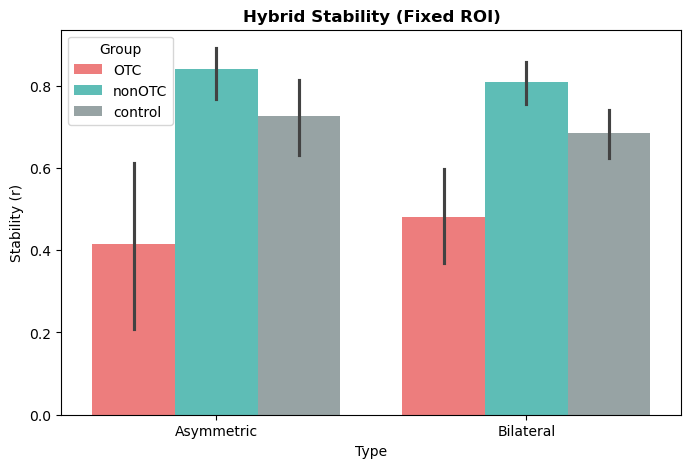

              mean                count          
Type    Asymmetric Bilateral Asymmetric Bilateral
Group                                            
OTC          0.414     0.480          9         9
control      0.726     0.685         34        36
nonOTC       0.841     0.808         18        18


In [5]:
# CELL 5: Hybrid Stability (Fixed ROI + Robust Extraction)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from pathlib import Path

def compute_hybrid_stability(functional_results, subjects, min_voxels=50):
    # 1. Define Dictionaries locally to ensure independence
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {
        'face': 'Asymmetric',
        'word': 'Asymmetric',
        'house': 'Bilateral',
        'object': 'Bilateral'
    }
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        # Get valid sessions
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        first_ses = sessions[0]
        
        for roi_name, roi_data in res.items():
            cat = roi_name.split('_')[1]
            if first_ses not in roi_data: continue
            
            # 1. Fixed ROI from Session 1
            mask = roi_data[first_ses]['roi_mask']
            if np.sum(mask) < min_voxels: continue
            
            # 2. Extract using Robust Cope
            patterns = {}
            valid_extraction = True
            
            for ses in sessions:
                # Construct Path (Assumes BASE_DIR is defined globally, otherwise pass it in)
                f = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z = f / f'cope{EXTRACTION_MAP[cat]}.feat' / 'stats' / ('zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz')
                
                if z.exists():
                    try: 
                        patterns[ses] = nib.load(z).get_fdata()[mask]
                    except: 
                        valid_extraction = False
                else:
                    valid_extraction = False
            
            # 3. Correlate
            if valid_extraction and sessions[-1] in patterns:
                # Ensure variance is not zero
                if np.std(patterns[first_ses]) > 0 and np.std(patterns[sessions[-1]]) > 0:
                    corr = np.corrcoef(patterns[first_ses], patterns[sessions[-1]])[0,1]
                    
                    data.append({
                        'Group': info['group'], 
                        'Category': cat.capitalize(),
                        'Type': CATEGORY_TYPES.get(cat, 'Other'), 
                        'Stability (r)': corr
                    })
                
    df = pd.DataFrame(data)
    
    if not df.empty:
        plt.figure(figsize=(8,5))
        sns.barplot(data=df, x='Type', y='Stability (r)', hue='Group', 
                    palette={'OTC': '#ff6b6b', 'nonOTC': '#4ecdc4', 'control': '#95a5a6'},
                    order=['Asymmetric', 'Bilateral'])
        plt.title("Hybrid Stability (Fixed ROI)", fontweight='bold')
        plt.axhline(0, color='k', linewidth=0.5)
        plt.show()
        
        print(df.groupby(['Group', 'Type'])['Stability (r)'].agg(['mean', 'count']).unstack().round(3))
    else:
        print("No valid data found for plotting.")
        
    return df

df_hybrid = compute_hybrid_stability(golarai_functional_final, ANALYSIS_SUBJECTS)

In [6]:
# CELL 6: Drift Analysis
import numpy as np
import pandas as pd

def analyze_drift(functional_results, subjects, min_voxels=50):
    # Define locally
    CATEGORY_TYPES = {
        'face': 'Asymmetric',
        'word': 'Asymmetric',
        'house': 'Bilateral',
        'object': 'Bilateral'
    }
    
    data = []
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        
        for roi_name, roi_data in res.items():
            cat = roi_name.split('_')[1]
            first, last = sessions[0], sessions[-1]
            
            if first in roi_data and last in roi_data:
                if roi_data[first]['n_voxels'] >= min_voxels:
                    c1 = np.array(roi_data[first]['centroid'])
                    c2 = np.array(roi_data[last]['centroid'])
                    dist = np.linalg.norm(c2 - c1)
                    
                    data.append({
                        'Group': info['group'], 
                        'Category': cat.capitalize(),
                        'Type': CATEGORY_TYPES.get(cat, 'Other'), 
                        'Drift (mm)': dist
                    })
    
    df = pd.DataFrame(data)
    if not df.empty:
        print(df.groupby(['Group', 'Category'])['Drift (mm)'].mean().unstack().round(2))
    return df

df_drift = analyze_drift(golarai_functional_final, ANALYSIS_SUBJECTS)

Category  Face  House  Object   Word
Group                               
OTC       7.99   7.06    5.85  13.96
control   7.01   6.34    4.28  12.19
nonOTC    3.04   5.00    2.19   9.77


In [7]:
# CELL 7: RDM Stability (Geometry)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from scipy.spatial.distance import squareform

def analyze_rdm(functional_results, subjects, min_voxels=30):
    # Define locally
    RDM_CATS = ['face', 'house', 'object', 'word']
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {
        'face': 'Asymmetric',
        'word': 'Asymmetric',
        'house': 'Bilateral',
        'object': 'Bilateral'
    }
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        first, last = sessions[0], sessions[-1]
        
        for roi_name, roi_data in res.items():
            roi_cat = roi_name.split('_')[1]
            
            if first not in roi_data or last not in roi_data: continue
            
            # Dynamic Masks
            m1, m2 = roi_data[first]['roi_mask'], roi_data[last]['roi_mask']
            if np.sum(m1) < min_voxels or np.sum(m2) < min_voxels: continue
            
            try:
                # Build RDM 1
                feats1 = []
                for c in RDM_CATS:
                    f = BASE_DIR/sid/f'ses-{first}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[c]}.feat'/'stats'/'zstat1.nii.gz'
                    feats1.append(nib.load(f).get_fdata()[m1])
                
                # Build RDM 2
                feats2 = []
                for c in RDM_CATS:
                    f = BASE_DIR/sid/f'ses-{last}'/'derivatives'/'fsl'/'loc'/'HighLevel.gfeat'/f'cope{EXTRACTION_MAP[c]}.feat'/'stats'/f'zstat1_ses{first}.nii.gz'
                    feats2.append(nib.load(f).get_fdata()[m2])
                
                # Calc RDMs
                rdm1 = 1 - np.corrcoef(np.array(feats1))
                rdm2 = 1 - np.corrcoef(np.array(feats2))
                
                # Fix Symmetry
                rdm1 = (rdm1 + rdm1.T)/2; np.fill_diagonal(rdm1, 0)
                rdm2 = (rdm2 + rdm2.T)/2; np.fill_diagonal(rdm2, 0)
                
                corr = np.corrcoef(squareform(rdm1), squareform(rdm2))[0,1]
                
                data.append({
                    'Group': info['group'], 
                    'Type': CATEGORY_TYPES.get(roi_cat, 'Other'),
                    'RDM Stability (r)': corr
                })
            except: pass
            
    df = pd.DataFrame(data)
    if not df.empty:
        print(df.groupby(['Group', 'Type'])['RDM Stability (r)'].mean().unstack().round(3))
    return df

df_rdm = analyze_rdm(golarai_functional_final, ANALYSIS_SUBJECTS)

Type     Asymmetric  Bilateral
Group                         
OTC           0.343      0.245
control       0.598      0.553
nonOTC        0.496      0.779
